
<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Introduction to Xarray
**ESDS 2024 Annual Event Xarray-Dask Tutorial | January 19th, 2024**  

Negin Sobhani and Brian Vanderwende
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

------

### In this tutorial, you learn:

* What is Xarray?
* The basic data structures in Xarray.
* Read and write netCDF files using Xarray.
* Basic computations with Xarray.
* High-level computations with Xarray. 
* Xarray wrapping other array types.

### Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| Basic familiarity with NumPy	 | Necessary | |
| Basic familiarity with Pandas	 | Necessary | |

- **Time to learn**: 75 minutes

---------

<img src="https://docs.xarray.dev/en/stable/_static/Xarray_Logo_RGB_Final.svg"
     width="50%"
     alt="Xarray"
     style="vertical-align:middle;margin:30px 0px"/>

## Introduction

### What is Xarray?
     
Xarray is an open-source Python library designed for working with *labelled multi-dimensional* data. 

By *multi-dimensional* data (also often called *N-dimensional*), we mean data that has many independent dimensions or axes (e.g. latitude, longitude, time).

By *labelled* we mean that these axes or dimensions are associated with coordinate names (like "latitude") and coordinate labels like "30 degrees North".

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png"
     width="50%"
     alt="Xarray"
     style="vertical-align:middle;margin:30px 0px"/>

*Image credit: Xarray Contributors*

The diagram above shows an example of a labelled multi-dimensional data with two variables (`temperature` and `precipitation`) and three coordinate vectors (e.g., `latitude`, `longitude`, `time`) that describe the data.
     
### Xarray Fundamental Data Structures

Xarray has two fundamental data structures:

* `DataArray` : holds a single multi-dimensional variable and its coordinates
* `Dataset` : holds multiple DataArrays that potentially share the same coordinates


#### Xarray DataArray

**Xarray DataArray = data + (a lot of) metadata**

A `DataArray` has four attributes:
* **Underlying Data** or `data`: a Numpy or Numpy-like array holding the values.
* **Named Dimensions** or `dims`: dimension names for each axis (e.g., `latitude`, `longitude`, `time`).
* **Coordinate Variables** or `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings).
* **Arbitrary attributes** or `attrs`: a dictionary to hold arbitrary metadata (attributes).

#### Xarray DataSet

**Xarray Dataset = multiple DataArrays**

A dataset is simply an object containing multiple Xarray DataArrays indexed by variable name that potentially share the same coordinates.

First let's open a tutorial dataset and see what these data structures look like. Here we'll use `air temperature` from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). Xarray objects have convenient HTML representations to give an overview of what we're working with:

In [116]:
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data=False);

In [118]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes: (5)

Checkout the variables and coordinates of the dataset. You can also create a Data Array from the dataset:

In [119]:
da = ds['air']
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

What are the named dimensions of this data array?

In [120]:
da.dims

('time', 'lat', 'lon')

What are the coordinates of this data array?

In [124]:
da.coords

Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

What are the attributes of this data array?

In [129]:
da.attrs

{'long_name': '4xDaily Air temperature at sigma level 995',
 'units': 'degK',
 'precision': 2,
 'GRIB_id': 11,
 'GRIB_name': 'TMP',
 'var_desc': 'Air temperature',
 'dataset': 'NMC Reanalysis',
 'level_desc': 'Surface',
 'statistic': 'Individual Obs',
 'parent_stat': 'Other',
 'actual_range': array([185.16, 322.1 ], dtype=float32)}

-----------------

## Reading and Writing Data with Xarray

One of Xarray's most widely used features is its ability to [read from and write
to a variety of data formats](https://docs.xarray.dev/en/stable/user-guide/io.html). 
For example, Xarray can read the following formats using `open_dataset`/`open_mfdataset`:

- [NetCDF](https://www.unidata.ucar.edu/software/netcdf/)
- [Zarr](https://zarr.readthedocs.io/en/stable/)
- [HDF5](https://www.hdfgroup.org/solutions/hdf5/)

Support for additional formats is possible using external packages
- [GRIB](https://en.wikipedia.org/wiki/GRIB) using the [cfgrib](https://github.com/ecmwf/cfgrib) package
- [GeoTIFF](https://gdal.org/drivers/raster/gtiff.html) /
  [GDAL rasters](https://svn.osgeo.org/gdal/tags/gdal_1_2_5/frmts/formats_list.html)
  using the [rioxarray package](https://corteva.github.io/rioxarray/stable/)

<img src="https://www.unidata.ucar.edu/images/logos/netcdf-400x400.png" align="right" width="20%">

### NetCDF
Xarray dataset is built upon the netCDF data model, which means that netCDF files stored on disk directly represent Dataset objects. 


Xarray reads and writes to NetCDF files using the `open_dataset` /
`open_dataarray` functions and the `to_netcdf` method, respectively.

#### Reading NetCDF file(s) with Xarray

Xarray provides a function called `open_dataset` that allows us to load a netCDF dataset into a Python data structure. To read more about this function, please see [xarray `open_dataset` API documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). 

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood. We will learn more about this later in the tutorial. 


In this example, we are going to open one file from CESM2 Large Ensemble Data Sets (LENS). 
We will use near-surface air temperature (TREFHT) for this analysis. 

To learn more about LENS2 dataset, please visit:
* [LENS official website](https://www.cesm.ucar.edu/community-projects/lens/data-sets)
* [LENS paper](https://www.cesm.ucar.edu/community-projects/lens/data-sets)

For this tutorial, we only look at a small subset of data. If you don't have the data, running the following code enables you to download, prepare, and stage the required datasets (`../data/` folder) for this notebook.

This [page](https://www.cesm.ucar.edu/models/cesm2/naming-conventions#:~:text=The%20naming%20conventions%20for%20CESM,%22post%2Dprocessed%20data%22.) provides more information about CESM2 output file naming conventions.

let's read one file to see what's in it: 

In [145]:
import os
data_dir = '../data/'
this_file = os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.201501-202412.nc')

ds = xr.open_dataset(this_file) 
ds

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33,
                   time: 120)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2025-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 ...
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    ...            ...
    n2ovmr        (time) float64 ...
    f11vmr        (time) float64 ...
    f12vmr        (time) float64 ...
    sol_tsi       (time) float64 ...
    nsteph        (time) int32 ...
    TREFHT        (time, lat, lon) float32 ...
Attributes: (9)

For this tutorial, we are looking at near-surface air temperature (TREFHT). 

This is a 3D variable, with dimensions of time, latitude, and longitude. We can see this by looking at the dimensions of the variable:

In [142]:
tref = ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (time: 120, lat: 192, lon: 288)>
[6635520 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2025-01-01 00:00:00
Attributes: (3)

The attributes make it easy to work with the netCDF file metadata. For example what is the unit of the variable?

In [149]:
tref.attrs['units']

'K'

## Xarray Indexing and Selecting Data

Xarray supports different ways to index and select data. Xarray indexing is what makes it so powerful for data analysis tasks. 💪

In total, xarray supports four different kinds of indexing, as explained below and summarized in this table:

| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |

----------

### Positional indexing 
Xarray supports numpy-style positional indexing. For example, if we want to select the first element of the `lat` dimension, we can use the following syntax (0-based indexing similar to NumPy).

In [152]:
tref[:, 20, 0]

<xarray.DataArray 'TREFHT' (time: 120)>
[120 values with dtype=float32]
Coordinates:
    lat      float64 -71.15
    lon      float64 0.0
  * time     (time) object 2015-02-01 00:00:00 ... 2025-01-01 00:00:00
Attributes: (3)

but wait, which dimension is the `lat` dimension? Is it (lat,lon,time) or (time,lon,lat) or (time, lat,lon)? Also what lat/lon value does the this correspond to?

Xarray offers extremely flexible indexing routines that makes it easy to select data based on dimension names and coordinates instead of axis indices.

### Positional Indexing Using Dimension Names (`.isel`)

Xarray eliminates much of the mental overhead of remembering dimension orders by allowing indexing using dimension names and `isel`:

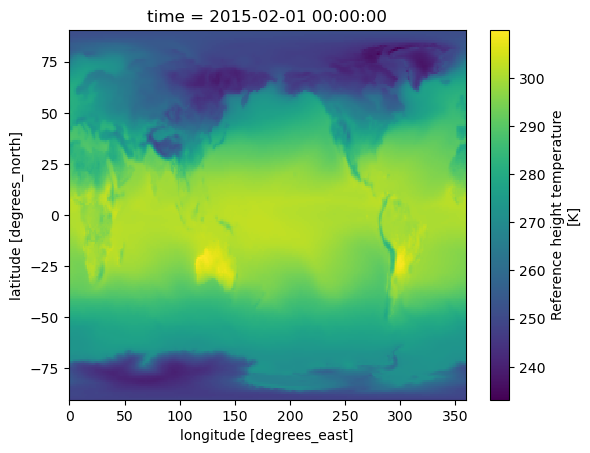

In [169]:
tref.isel(time=0).plot();

Slicing with labels is also possible. For example, we can plot the first 20 time steps of the variable:

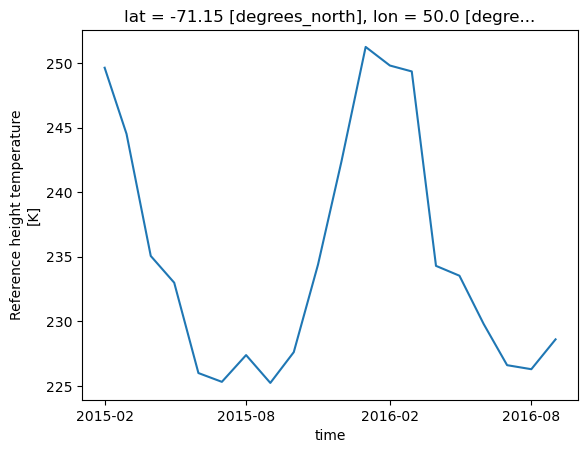

In [170]:
tref.isel(time=slice(0, 20), lat=20, lon=40).plot();

This is great! But it still requires you to know which index corresponds to your desired label. What if you don’t know the index of the label you want?

For example, what if you want to select the data for Lat 25 °N and Lon 210 °E, but you don’t know which index corresponds to this point. 

### Label-based Indexing Using Dimension Names

Xarray provides a more robust way to index data using dimension names and labels (instead of indices) using `.sel` method.

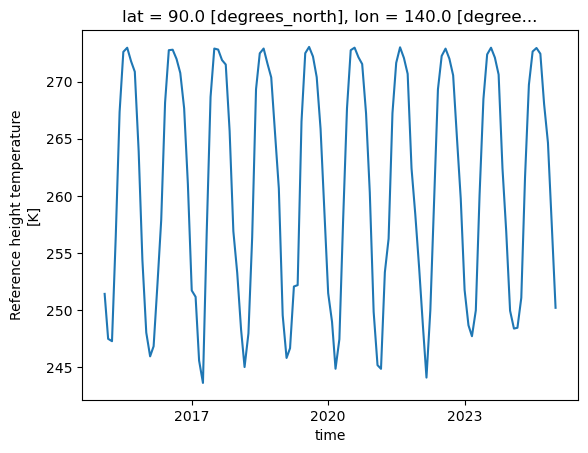

In [108]:
tref.sel(lat=90. , lon=140.).plot();

We can also do slicing using labels. For example: 

In [173]:
da.sel(lat=slice(50, 25), lon=slice(210, 215))

<xarray.DataArray 'air' (time: 2920, lat: 11, lon: 3)>
279.5 280.1 280.6 279.4 280.3 281.3 ... 295.0 294.6 294.2 295.5 295.6 295.1
Coordinates:
  * lat      (lat) float32 50.0 47.5 45.0 42.5 40.0 ... 35.0 32.5 30.0 27.5 25.0
  * lon      (lon) float32 210.0 212.5 215.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

This is a very powerful feature of Xarray. It allows you to select data without having to remember the order of dimensions or the indices of labels. 💪 🎉

#### Nearest-neighbor lookups

But what if that exact coordinate does not exist in my lat and lon coordinates? 

The label based selection methods `.sel()` support method and tolerance keyword argument. The `method` parameter allows for enabling nearest neighbor (inexact) lookups by use of the methods `pad`, `backfill` or `nearest`. The `tolerance` parameter allows for specifying a maximum distance for a valid match:

For example let's make a plot for NSF NCAR Mesa Lab. We can find it's nearest point by using the `method='nearest'` argument. 

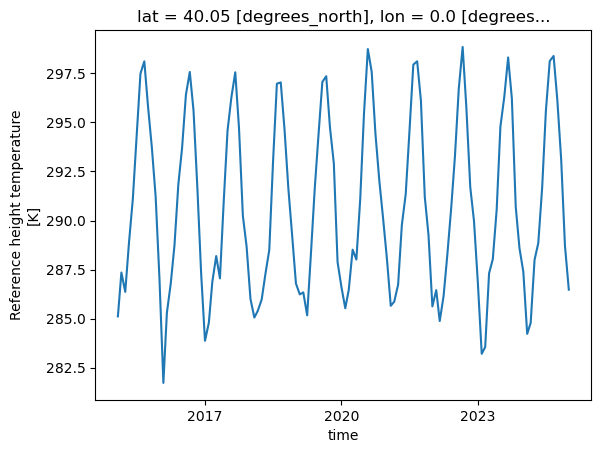

In [176]:
tref.sel(lat=40.0150, lon=-105.2705, method='nearest').plot()

### DateTime Indexing 

Datetime indexing is a critical feature when working with time series data. Essentially, datetime indexing allows you to select data points or a series of data points that correspond to certain date or time criteria. 

In [178]:
tref.sel(time='2017-01-01')

<xarray.DataArray 'TREFHT' (time: 1, lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2017-01-01 00:00:00
Attributes: (3)

By default, datetime selection will return a range of values that match the provided string. We can use this feature to select all points in a year:

In [179]:
tref.sel(time="2024")

<xarray.DataArray 'TREFHT' (time: 12, lat: 192, lon: 288)>
[663552 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2024-01-01 00:00:00 ... 2024-12-01 00:00:00
Attributes: (3)

Now, let’s say we want to select data between a certain range of dates. We can still use the `.sel()` method, but this time we will combine it with `slice`:

In [183]:
# This will return a subset of the dataset corresponding to specific dates
tref.sel(time=slice('2015-08-01', '2017-12-31'))

<xarray.DataArray 'TREFHT' (time: 29, lat: 192, lon: 288)>
[1603584 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-08-01 00:00:00 ... 2017-12-01 00:00:00
Attributes: (3)

#### Fancy indexing based on year, month, day, or other datetime components

In addition to the basic datetime indexing techniques, Xarray also supports “fancy” indexing options, which can provide more flexibility and efficiency in your data analysis tasks. You can directly access datetime components such as year, month, day, hour, etc. using the`.dt` accessor. Here is an example of selecting all data points from July across all years:

In [187]:
tref.sel(time=ds.time.dt.month == 7)

<xarray.DataArray 'TREFHT' (time: 10, lat: 192, lon: 288)>
[552960 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-07-01 00:00:00 ... 2024-07-01 00:00:00
Attributes: (3)

Xarray powerful indexing features make it really powerfull for working with multi-dimensional data.

<div class="alert alert-success" markdown="1">

All of these indexing methods work on the dataset too!

</div>

## Basic Computations with Xarray

Xarray data arrays and datasets are compatible with arithmetic operators and numpy array functions. 

For example, we can use the arithmetic operators `+`, `-`, `*`, `/`, `**` to add, subtract, multiply, divide, and exponentiate two xarray objects with the same dimensions. Let's convert the temperature values from Kelvin to Celsius by subtracting 273.15 from it:

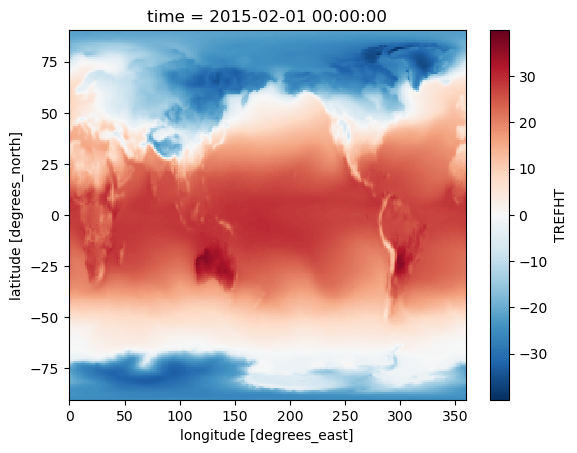

In [189]:
# change the unit from Kelvin to degree Celsius 
tref_c=tref-273.15
tref_c[0,:,:].plot();

# tref[0,:,:]-273.15).plot(); # this also works


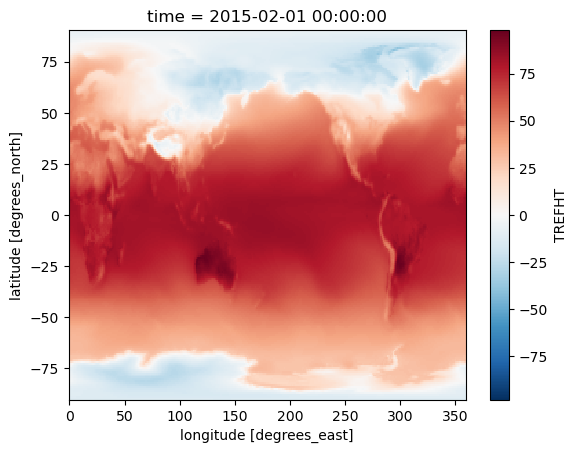

In [190]:
((tref[0,:,:] - 273.15) * 9/5 + 32).plot();

### Aggregation or Reduction Operations

Similar to NumPy, Xarray provides a set of basic statistical functions that operate on arrays. For example, we can compute the mean, standard deviation, variance, min, max, etc. of an xarray object.
 
For example, we can compute the mean of the temperature values over the time dimension:

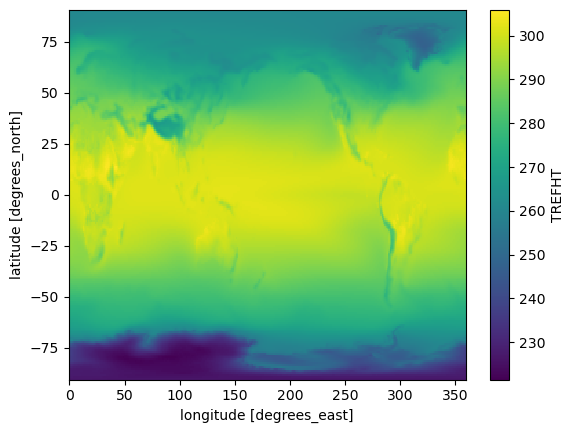

In [120]:
mean_temp = tref.mean(dim="time")
mean_temp.plot();

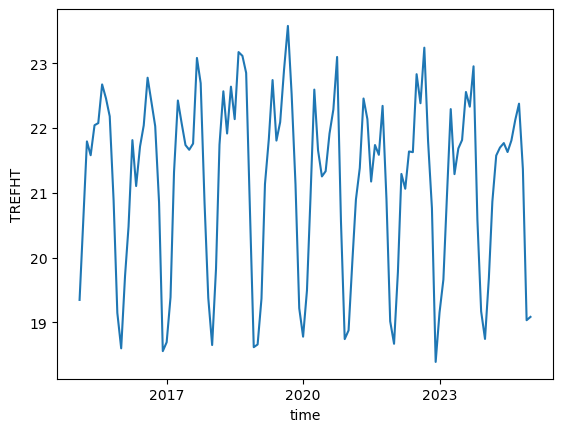

In [125]:
tref.std(dim=["lat", "lon"]).plot()

---

## High level computation 

(`groupby`, `resample`, `rolling`, `coarsen`, `weighted`)

Xarray has some very useful high level objects that let you do common
computations:

1. `groupby` :
   [Bin data in to groups and reduce](https://docs.xarray.dev/en/stable/groupby.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
1. `rolling` :
   [Operate on rolling windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Downsample your data](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `weighted` :
   [Weight your data before reducing](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions)


Below we quickly demonstrate these patterns. See the user guide links above and [the tutorial](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) for more.

### groupby

`groupby` is a powerful method that allows you to group DataArrays and Datasets by one or more dimensions. It is similar to the `groupby` method in Pandas.


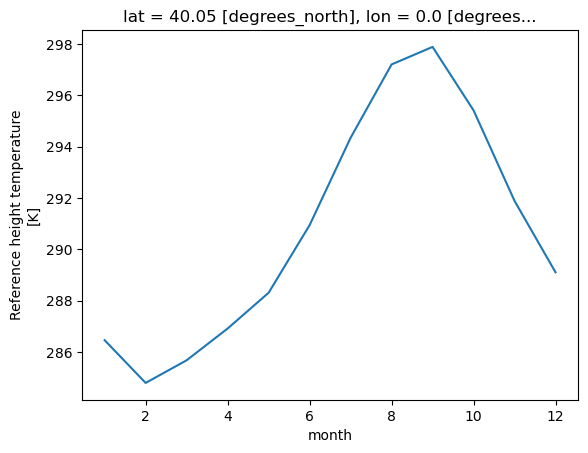

In [193]:
# calculate the monthly mean
monthly_mean = tref.groupby("time.month").mean()
monthly_mean.sel(lat=40.0150, lon=-105.2705, method='nearest').plot();

In [194]:
# make a seasonal mean
seasonal_mean = tref.groupby("time.season").mean()
seasonal_mean

<xarray.DataArray 'TREFHT' (season: 4, lat: 192, lon: 288)>
242.9 242.9 242.9 242.9 242.9 242.9 ... 269.1 269.1 269.1 269.1 269.1 269.1
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (3)

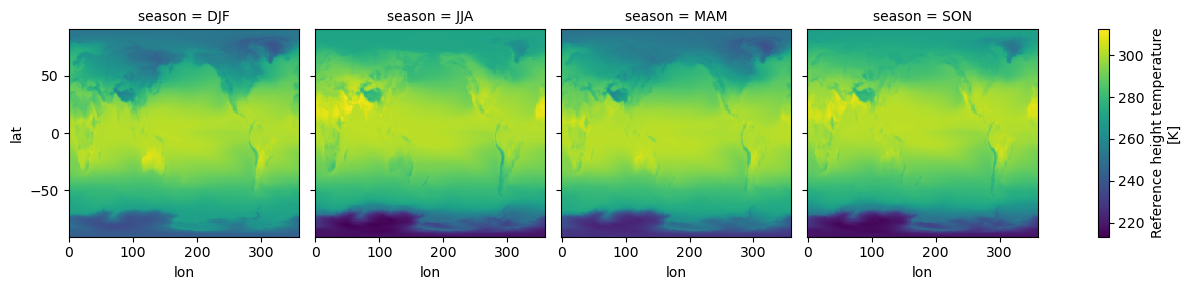

In [195]:
seasonal_mean.plot(col="season");

The seasons are out of order (they are alphabetically sorted). This is a common
annoyance. The solution is to use `.sel` to change the order of labels.


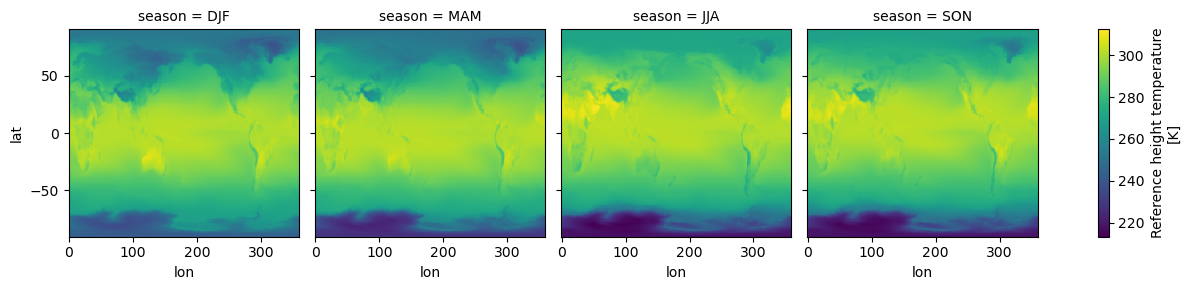

In [196]:
seasonal_mean = seasonal_mean.sel(season=["DJF", "MAM", "JJA", "SON"])
seasonal_mean.plot(col="season");

### Resampling

Resampling is a method for frequency conversion and downsampling of time-series data. Xarray provides a method called `resample` that allows you to resample time series data. `resample` can be applied only to time-index dimension. resampling change the length of the array.


In [261]:
# resample to 6-month frequency
tref_resample = tref.resample(time="6ME").mean()
tref_resample

<xarray.DataArray 'TREFHT' (time: 21, lat: 192, lon: 288)>
248.4 248.4 248.4 248.4 248.4 248.4 ... 262.6 262.6 262.6 262.6 262.6 262.6
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-28 00:00:00 ... 2025-02-28 00:00:00
Attributes: (3)

### Weighted

Weighted array reductions in Xarray give users with the ability to perform aggregations on multidimensional arrays **while assigning specific weights to each point**. It currently support weighted `sum`, `mean`, `std`, `var`, and `quantile`.

For example, the weighted mean is another way to smooth data, taking into account the varying importance of each data point.

In [254]:
#For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(tref.lat))
weights.name = "weights"

# calculate weighted means
weighted_mean=tref_c.weighted(weights).mean(["lat", "lon"])

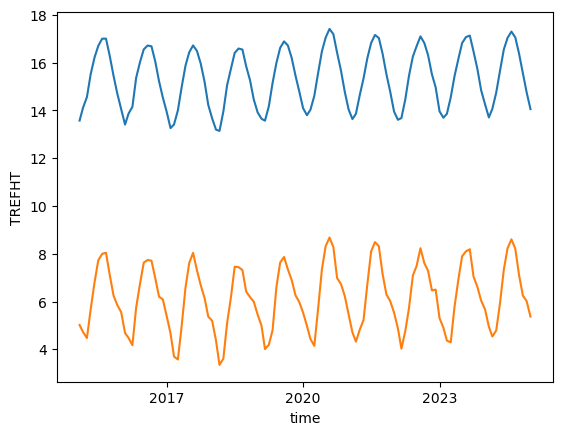

In [255]:
weighted_mean.plot(label="weighted");
tref_c.mean(["lat", "lon"]).plot(label="unweighted");

Similarly we can calculate weighted sum or weighted quantile, etc. To learn more about weighted array reduction, please see the [user guide](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.weighted.html).

### Rolling

Xarray provides a method called `rolling` that allows you to perform rolling window operations on your data. Rolling window operations can be applied along one or more dimensions of an xarray object.

For example, you can calculate the rolling mean of a time series to smooth out short-term fluctuations and highlight long-term trends. **`rolling` does not change the length of the arrays.** Instead, it allows a moving window to be applied to the data at each point.


In [256]:
tref

<xarray.DataArray 'TREFHT' (time: 120, lat: 192, lon: 288)>
array([[[248.39987, 248.39989, ..., 248.39989, 248.39989],
        [248.95004, 248.9094 , ..., 248.97466, 248.9626 ],
        ...,
        [251.34143, 251.35114, ..., 251.32008, 251.3312 ],
        [251.35237, 251.35286, ..., 251.35123, 251.35182]],

       [[237.44759, 237.44759, ..., 237.44759, 237.44759],
        [238.10292, 238.05934, ..., 238.14326, 238.12119],
        ...,
        [246.70511, 246.7112 , ..., 246.69476, 246.69987],
        [247.26158, 247.26067, ..., 247.2637 , 247.26259]],

       ...,

       [[234.76149, 234.76149, ..., 234.76149, 234.76149],
        [235.73701, 235.71188, ..., 235.7403 , 235.73915],
        ...,
        [258.31226, 258.319  , ..., 258.29547, 258.3044 ],
        [257.82   , 257.8217 , ..., 257.8161 , 257.81815]],

       [[243.92653, 243.92653, ..., 243.92653, 243.92653],
        [244.70544, 244.66684, ..., 244.73471, 244.7221 ],
        ...,
        [250.68085, 250.69714, ..., 250.64534, 250.66351],
        [250.34363, 250.34508, ..., 250.34027, 250.34203]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2025-01-01 00:00:00
Attributes: (3)

In [257]:
tref_rolling = tref.rolling(time=6, center=True).mean()
tref_rolling

<xarray.DataArray 'TREFHT' (time: 120, lat: 192, lon: 288)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2025-01-01 00:00:00
Attributes: (3)

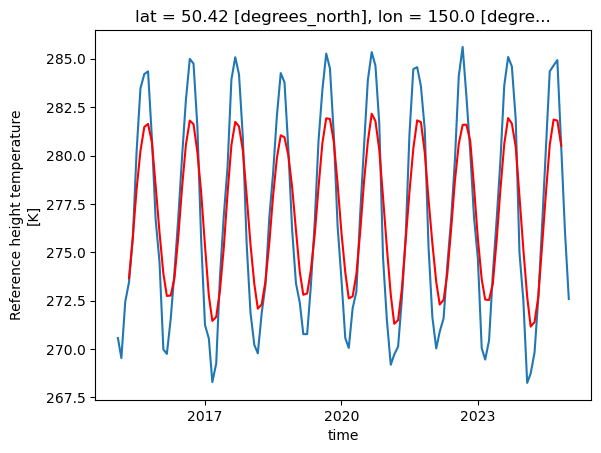

In [258]:
tref.sel(lon=150, lat=50, method='nearest').plot(label='monthly mean')
tref_rolling.sel(lon=150, lat=50, method='nearest').plot( label='6 month rolling mean', color='r')


### Coarsen

In Xarray, the coarsen operation is a powerful tool for downsampling or reducing the size of large arrays. When dealing with large datasets, coarsening allows for efficient summarization of data by aggregating multiple values into a single value within a defined coarsening window. This process is particularly useful when working with high-resolution or fine-grained data, as it enables the transformation of large arrays into smaller ones while preserving the overall structure and key characteristics of the data. `coarsen` is similar to `resample` when operating on time series data, but it can be applied to any dimension.



In order to take a block mean for every 5 lat and lon points we can use the following:

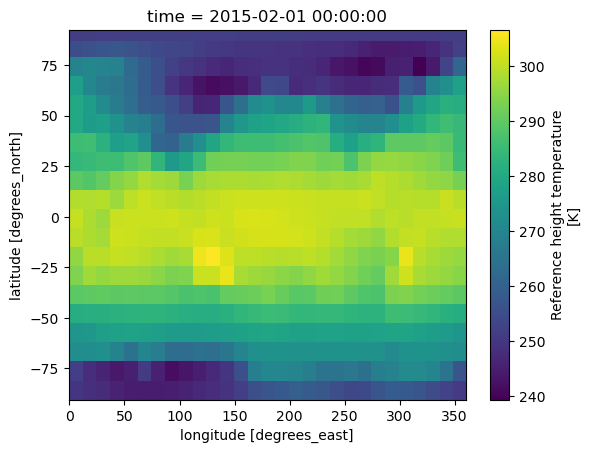

In [262]:
coarsen_da = tref.coarsen(lat=10, lon=10, boundary='pad').mean()
coarsen_da.isel(time=0).plot();

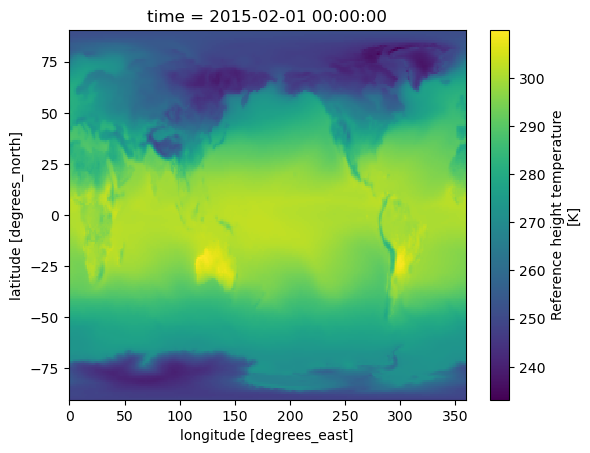

In [263]:
tref.isel(time=0).plot();

## Visualization (`.plot`)

We have seen very simple plots earlier. Xarray also lets you easily visualize 3D and 4D datasets by presenting multiple facets (or panels or subplots) showing variations across rows and/or columns.

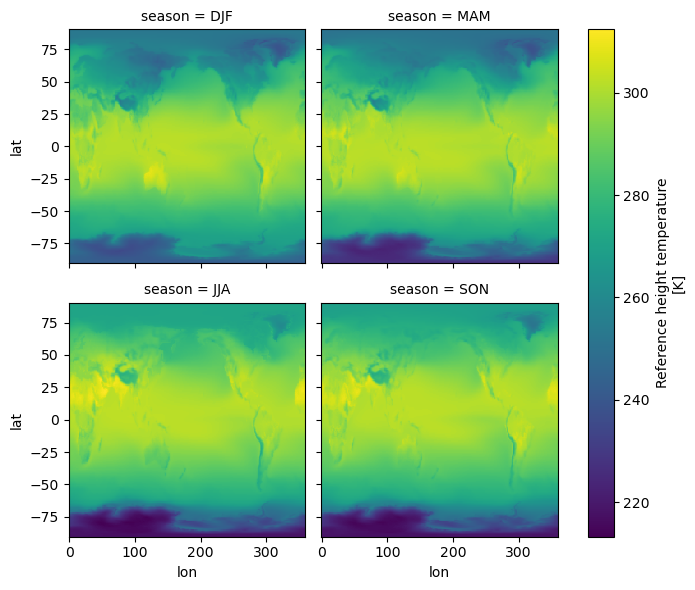

In [189]:
# facet the seasonal_mean
seasonal_mean.plot(col="season", col_wrap=2);

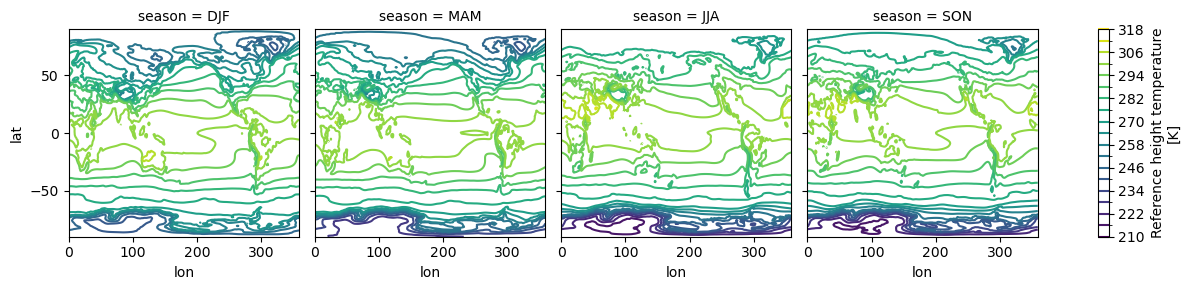

In [265]:
# contours
seasonal_mean.plot.contour(col="season", levels=20, add_colorbar=True);

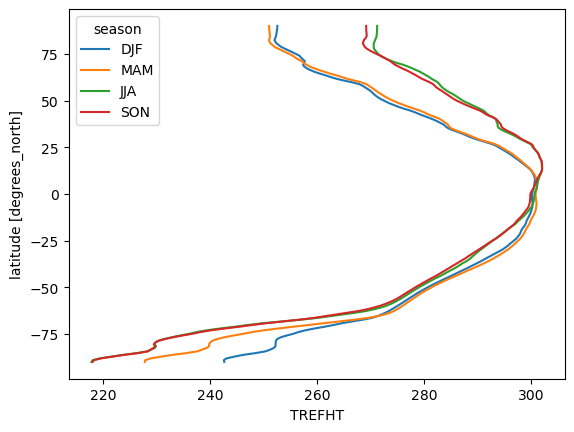

In [266]:
# cool line plots too? wut !
seasonal_mean.mean("lon").plot.line(hue="season", y="lat");

## Computing with Multiple Objects

### Broadcasting: adjusting arrays to the same shape

Broadcasting in Xarray refers to the automatic alignment and expansion of arrays to perform operations on arrays with different shapes and dimensions. It is a powerful feature that allows for efficient and convenient computations in Xarray. Broadcasting basically allows an operator or a function to act on two or more arrays to operate even if these arrays do not have the same shape. Xarray does broadcasting by dimension name, rather than array shape.

In [272]:
import numpy as np
array1 = xr.DataArray(
    np.arange(3),
    dims="space",
    coords={"space": ["a", "b", "c"]},
    name="array1",
)
array1

<xarray.DataArray 'array1' (space: 3)>
0 1 2
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'

In [268]:
array2 = xr.DataArray(
    np.arange(4),
    dims="time",
    coords={"time": [0, 1, 2, 3]},
    name="array2",
)
array2

Let's subtract this two:

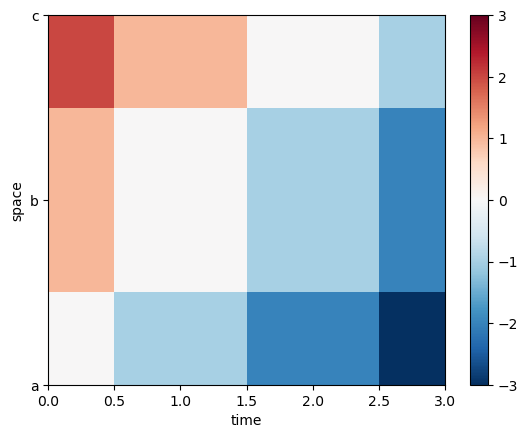

In [275]:
x= array1-array2
x.plot();


We see that the result is a 2D array.

When subtracting, Xarray first realizes that array1 is missing the dimension time and array2 is missing the dimension space. Xarray then broadcasts or “expands” both arrays to 2D with dimensions space, time. Here is an illustration:

<img src="https://tutorial.xarray.dev/_images/broadcasting_schematic.png" width="1000">

Credit: Stephan Hoyer – [xarray ECMWF Python workshop](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/)


Broadcasting in xarray simplifies the process of working with arrays of different shapes, as it automatically handles the alignment and expansion required for performing computations. It reduces the need for manual reshaping or padding of arrays, making the code more concise and readable. When doing certain computations on two arrays (additions), Xarray automatically broadcast the arrays to match the dimension shapes.  To learn more about `xarray.broadcast` , you can check [the user guide](https://docs.xarray.dev/en/stable/generated/xarray.broadcast.html).

<div class="alert alert-block alert-info" markdown="1">

If you encounter additional NaN values or missing data points after performing computations in xarray, it indicates that the coordinates of your xarray were not precisely aligned.
</div>

In [276]:
array1_broadcasted, array2_broadcasted = xr.broadcast(array1, array2)
display(array1_broadcasted.dims)
display(array2_broadcasted.dims)

('space', 'time')

('space', 'time')

### Alignment : Putting Data on the same grid

Alignment in xarray refers to the process of automatically aligning multiple DataArrays or Datasets based on their coordinates. For example, when combing two arrays using an arithmetic operation, both arrays must first be converted to the same coordinate system. 

Alignment ensures that the data along these coordinates is properly aligned before performing operations or calculations. This alignment is crucial because it enables xarray to handle operations on arrays with different sizes, shapes, and dimensions.



<img src="https://tutorial.xarray.dev/_images/alignment_schematic.png" width="1000">

Here are two 2D DataArrays with different shapes.


In [277]:
tref_mid = tref.sel(time = "2024-01", lat=slice(30,75))# 48 point
tref_high = tref.sel(time = "2024-01", lat=slice(75,90)) # 16 points
tref_mid.shape, tref_high.shape


((1, 48, 288), (1, 16, 288))

`tref_mid` and `tref_high` have the same dimensions (space, time) but have values at different locations in the (space, time) plane with some locations in common.

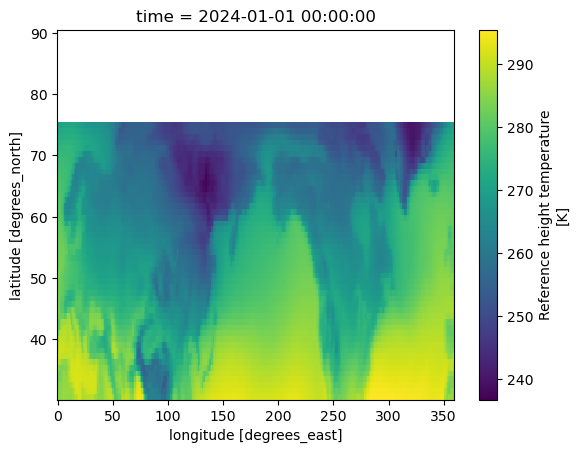

In [278]:
tref_mid_outer, tref_high_outer = xr.align(tref_mid, tref_high, join='outer')
tref_mid_outer.plot()

## Xarray can wrap many NumPy-like arrays


This notebook has focused on Numpy arrays. Xarray can wrap [other array](https://docs.xarray.dev/en/stable/user-guide/duckarrays.html) types! For example:

<img src="https://docs.dask.org/en/stable/_images/dask_horizontal.svg" width="20%"> [distributed parallel arrays](https://docs.dask.org/en/latest/array.html) & [Xarray user guide on Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html)


<img src="https://raw.githubusercontent.com/pydata/sparse/master/docs/logo.svg" width="10%"> **pydata/sparse** : [sparse arrays](https://sparse.pydata.org)

<img src="https://raw.githubusercontent.com/cupy/cupy.dev/master/images/cupy_logo.png" width="22%"> [GPU arrays](https://cupy.dev) & [cupy-xarray](https://cupy-xarray.readthedocs.io/)

<img src="https://pint.readthedocs.io/en/stable/_static/logo-full.jpg" width="10%"> **pint** : [unit-aware arrays](https://pint.readthedocs.io) & [pint-xarray](https://github.com/xarray-contrib/pint-xarray)


For example, we will learn more about Xarray wrapping Dask arrays in the next section.

## Parallelizing Xarray with Dask: A Gentle Introduction

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood.

This is especially helpful when the data does not fit into memory. In this case, Dask will automatically create a task graph and execute the tasks in parallel.

### Constructing Xarray Datasets from Files

In [50]:
# find all LENS files for 1 ensemble
data_dir = '../data'
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))

print("All files: [", len(files), "files]")

All files: [ 9 files]


In [51]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    # concatenate along this dimension
    concat_dim="time",
    # concatenate files in the order provided
    combine="nested",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the h5netcdf package to read them
    engine="h5netcdf",
    # hold off on decoding time
    decode_cf=False,
    # specify that data should be automatically chunked
    chunks="auto",
)
ds = xr.decode_cf(ds)
ds

CPU times: user 1.64 s, sys: 462 ms, total: 2.11 s
Wall time: 4.86 s


<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, time: 1032, nbnd: 2, lon: 288, lev: 32,
                   ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (time, zlon, nbnd) float64 dask.array<chunksize=(120, 1, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(120, 192), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(120, 32), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(120, 32), meta=np.ndarray>
    P0            (time) float64 ...
    hyai          (time, ilev) float64 dask.array<chunksize=(120, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(120,), meta=np.ndarray>
    TREFHT        (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Attributes: (9)

Let's look at the `TREFHT` variable representation in the dataset:

In [56]:
tref = ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (3)

Note that the `TREFHT` variable is a `dask.array` object. This means that the data is not yet loaded into memory. Instead, the data is stored as a set of tasks that can be executed in parallel.

<div class="alert alert-success" markdown="1">

Xarray automatically wraps Dask Arrays and Dask is lazy, meaning that operations are not computed until we explicitly request them, for example by calling `.compute()`.

</div>


In the next tutorial, we will talk more about "lazy evaluation" in Dask.

Let's take a quick look at the representation of `TREFHT` data:

In [57]:
tref.data

dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>

The represntation of `TREFHT` and `TREFHT.data` DataArray shows details of **chunks** and **chunk-sizes** of Xarray DataArray. But what is a chunk?

### Chunk 

Chunking is a technique for splitting up a larger array into a set of **sub-arrays** (or **chunks**). The way that arrays are chunked can significantly affect total performance.

We can use `.chunks` method to see the chunking of a DataArray:


In [59]:
tref.chunks

((120, 120, 120, 120, 120, 120, 120, 120, 72), (192,), (288,))

* How many chunks do we have? 
* What is the size of each chunk size?

Here we can see that we have a total of 9 chunks - equal to the number of our netCDF files. In general `open_mfdataset` will return one chunk per netCDF file.

<div class="alert alert-block alert-warning">

**WARNING:** The chunk structure within the file is important. When re-chunking the dataset after creation with `ds.chunk()` it is recommended to only use multiples of the on-file chunk shape.

</div>

We can check what that shape is by looking at the encoding:

In [61]:
tref.encoding

{'chunksizes': (1, 192, 288),
 'fletcher32': False,
 'shuffle': True,
 'preferred_chunks': {'time': 1, 'lat': 192, 'lon': 288},
 'zlib': True,
 'complevel': 1,
 'source': '/Users/negins/ESDS-Xarray-Dask-2024/ESDS-Xarray-Dask-2024/data/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.201501-202412.nc',
 'original_shape': (120, 192, 288),
 'dtype': dtype('<f4')}

<div class="alert alert-block alert-info" markdown="1">

**TIP:** The `chunks` parameter can significantly affect total performance when using Dask Arrays. `chunks` should be small enough that each chunk fit in the memory, but large enough to avoid that the communication overhead. 

</div>

A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements. Here we have 120x192x288 elements in each chunk (except for the last chunk).   
With large arrays (10+ GB), the cost of queuing up Dask operations can be noticeable, and you may need even larger chunksizes. 

**Additional Reading**

 - [dask.array best practices](https://docs.dask.org/en/stable/array-best-practices.html#select-a-good-chunk-size)
 - [NCAR chunking tutorial](https://ncar.github.io/dask-tutorial/notebooks/06-dask-chunking.html)
 - [Dask blog post on chunking](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)

Now, let' calculate the monthly anomaly: 

In [64]:
%%time

# Compute monthly anomaly

# -- 1. calculate monthly average
tref_grouped = tref.groupby('time.month')
tmean = tref_grouped.mean(dim='time')

#-- 2. calculate monthly anomaly
tos_anom = tref_grouped - tmean
tos_anom

CPU times: user 31.9 ms, sys: 30.6 ms, total: 62.5 ms
Wall time: 81.2 ms


/Users/negins/miniconda/envs/dask-cookbook/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [65]:
%%time
computed_anom = tos_anom.load()
type(computed_anom)

CPU times: user 1.09 s, sys: 267 ms, total: 1.36 s
Wall time: 1.22 s


xarray.core.dataarray.DataArray

Please note how `computed_anom` is a `dask.array` object. This means that the data has not yet been loaded into memory yet.

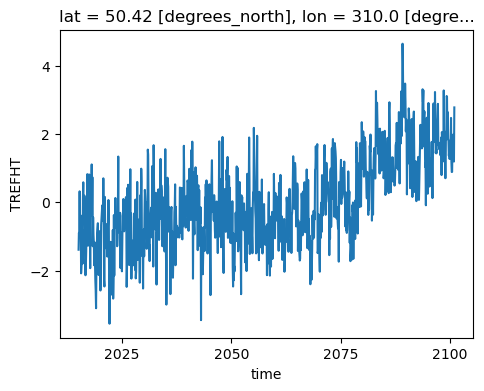

In [67]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot( size=4)

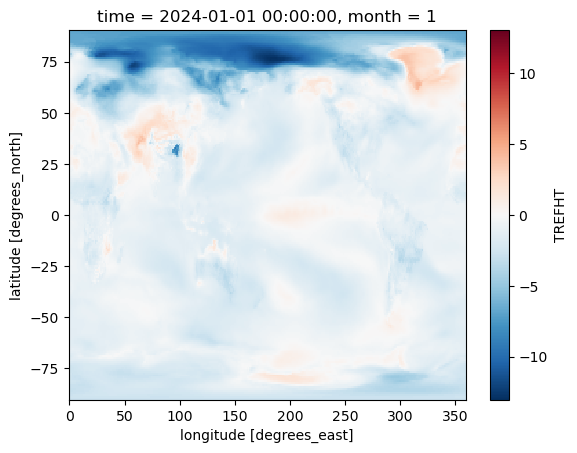

In [69]:
tos_anom.sel(time='2024-01-01').plot()

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> Using Xarray plotting functionality automatically triggers computations on the Dask Array, similar to `.compute()`.

</div>

### Dask + Xarray Good Practices

<div class="alert alert-success fade show" markdown="1">

* Similar to Dask DataFrames, it is more efficient to first do spatial and temporal indexing (e.g. .sel() or .isel()) and filter the dataset early in the pipeline, especially before calling resample() or groupby(). 

* Chunk sizes should be small enough to fit into the memory at once but large enough to avoid the additional communication overhead. Good chunk size ~100 MB. 

* It is always better to chunk along the `time` dimension. 

* When possible, use `xr.apply_ufunc` to apply an unvectorized function to the Xarray object. 

</div>

### Supplementary Material: Advanced using `apply_ufunc`

Sometimes, we want calculate a function that is not built-in to Xarray. For example, we may want to calculate the saturation vapor pressure.
`xr.apply_ufunc()` give users capability to run custom-written functions.  

Xarray, itself, use `apply_ufunc()` to implement many of its built-in functions. For example, this includes most of SciPy's API implementation in Xarray.

In the example below, we calculate the saturation vapor pressure by using `apply_ufunc()` to apply this function to our Dask Array chunk by chunk. 

In [ ]:
import numpy as np

def sat_p(t):
    """Calculate saturation vapor pressure using Clausius-Clapeyron equation"""
    return 0.611 * np.exp(17.67 * (t-273.15)*((t-29.65)**(-1)))

In [ ]:
es = xr.apply_ufunc(sat_p, da, output_dtypes=[float])
es

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
0.04237 0.04797 0.05273 0.05526 0.05578 0.0547 ... 3.026 2.989 2.866 2.814 2.73
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

The data used for this tutorial is from one ensemble member. What if we want to use multiple ensemble members? So far, we only run on one machine, what if we run an HPC cluster? We will go over this in the next tutorial.

## Summary

In this notebook, we have learned about:

* Xarray data structures: `DataArray` and `Dataset`
* Indexing and selecting data
* Reading and writing data with Xarray
* Basic computations with Xarray
* Broadcasting and alignment
* Customized workflows using `apply_ufunc`

## Resources and references

### Reference
* [Xarray Tutorial material](https://tutorial.xarray.dev/intro.html)
* [Project Pythia Foundations](https://foundations.projectpythia.org/core/xarray.html)
* [Advanced Indexing](https://tutorial.xarray.dev/intermediate/indexing/advanced-indexing.html)